# data_preprocessing

> This module contains utils for preprocessing data from stanford and tsinghua datasets into a uniform format

In [1]:
#| default_exp data_preprocessing

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
import sys
sys.path.append('../dog_breed_id')

# Data Exploration and Preprocessing
This notebook contains code required to explore and preprocess both `stanford_dogs` and `tsinghua_dogs` datasets. **This notebook assumes that both datasets have been downloaded and appropriately unzipped on disk.**. We set up path to these datasets in the next cell.

In [4]:
# For downlod instructions see 01_data_download.py
STANFORD_PATH = '../data/stanford_dogs'
TSINGHUA_PATH = '../data/tsinghua_dogs'
STANFORD_IMAGE_PATH = f'{STANFORD_PATH}/Images'
STANFORD_ANNOTATIONS_PATH = f'{STANFORD_PATH}/Annotation'
TSINGHUA_IMAGE_PATH = f'{TSINGHUA_PATH}/low-resolution'
TSINGHUA_ANNOTATIONS_PATH = f'{TSINGHUA_PATH}/Low-Annotations/'

In [5]:
#| export
import cv2
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from miniai.datasets import show_images

/Users/deman/Dev/SpringboardCapstone/dog_breed_id/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
%matplotlib inline

Let's visualize a few images from the Stanford Images Dataset

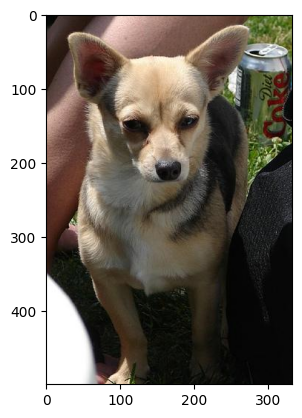

In [7]:
# Let's read an image from Stanford Dogs dataset
im01 = np.array(Image.open(f'{STANFORD_IMAGE_PATH}/n02085620-Chihuahua/n02085620_10074.jpg'))
plt.imshow(im01)

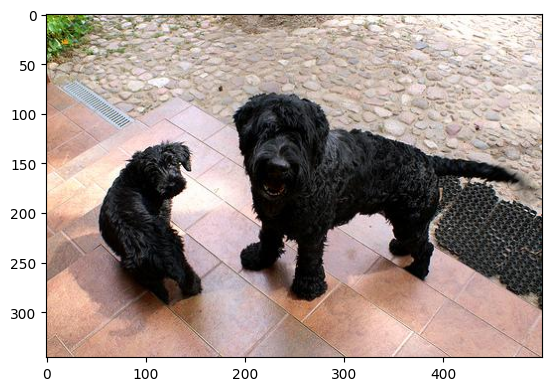

In [8]:
im02 = np.array(Image.open(f'{STANFORD_IMAGE_PATH}/n02097130-giant_schnauzer/n02097130_5668.jpg'))
plt.imshow(im02)

Now for each image, let's get the bounding box of the correponding dog and plot it as well

In [9]:
# export
def get_bboxes(impath, annotations_path, format='stanford'):
    """
    impath - path to the image on disk
    annotations_path - path to corresponding annotations folder
    format - one of 'stanford' or 'tsinghua'
    """
    assert format in ['stanford', 'tsinghua'], 'Format neither "stanford" nor "tsinghua"'
    import os
    import xml.etree.ElementTree as ET
    parts = impath.split(os.sep)
    imname = Path(os.sep.join(parts[-2:]))
    uniquename = imname.parent/imname.stem
    annotation_file = f'{annotations_path}/{uniquename}'
    if format == 'tsinghua':
        annotation_file += '.jpg.xml'
    root = ET.parse(annotation_file)
    boxes = []
    bndbox_index = 4
    bndbox = 'bndbox' if format=='stanford' else 'bodybndbox'
    for obj in root.iter('object'):
        boxelem = obj.find(bndbox)
        left, top, right, bottom = boxelem[0].text, boxelem[1].text, boxelem[2].text, boxelem[3].text
        left, top, right, bottom = map(int, [left, top, right, bottom])
        boxes.append([left, top, right, bottom])
    return boxes

In [10]:
boxes = get_bboxes(f'{STANFORD_IMAGE_PATH}/n02097130-giant_schnauzer/n02097130_5668.jpg',
                         annotations_path=STANFORD_ANNOTATIONS_PATH)
print(boxes)

[[190, 81, 474, 288], [52, 129, 157, 297]]


In [11]:
#| export
def annotated_image(image, boxes):
    """
    image - image to be annotated
    boxes - list of bounding boxes to be annotated
    """
    imann = image.copy()
    for box in boxes:
        cv2.rectangle(imann, tuple(map(int, box[:2])), tuple(map(int, box[2:])), (0, 255, 0), 2)
    return imann

In [12]:
imann = annotated_image(im02, boxes)

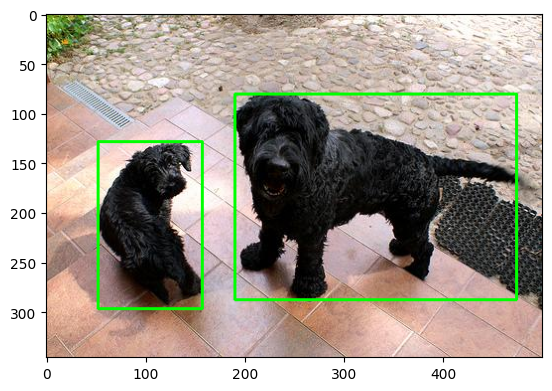

In [13]:
plt.imshow(imann)

Let's write some helper method to extract the breedname

In [14]:
#| export
def get_breedname(path, normalize=False):
    """
    impath - path to image or annotation
    normalize - if set to true, lowercases the name
    returns the name of the dog breed
    """
    import os
    parts = path.split(os.sep)
    breed = parts[-2].split('-')[-1]
    return breed if not normalize else breed.lower()

In [15]:
get_breedname(f'{STANFORD_IMAGE_PATH}/n02097130-giant_schnauzer/n02097130_5668.jpg')

'giant_schnauzer'

Note that the same set of methods will also work for **Tsinghua Dogs dataset**.

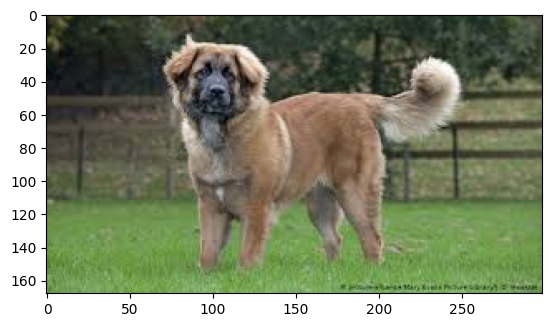

In [16]:
im03 = np.array(Image.open(f'{TSINGHUA_IMAGE_PATH}/214-n000019-Leonberg/n109320.jpg'))
plt.imshow(im03)

In [17]:
boxes = get_bboxes(f'{TSINGHUA_IMAGE_PATH}/214-n000019-Leonberg/n109320.jpg',
                annotations_path=TSINGHUA_ANNOTATIONS_PATH,
                format='tsinghua')

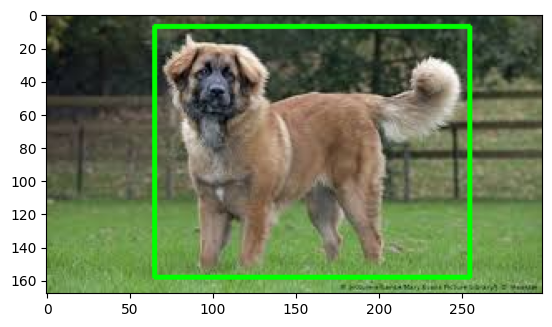

In [18]:
plt.imshow(annotated_image(im03, boxes))

Note that all images are of non-uniform sizes. In order to make use of a convolutional network, it is preferable to keep all images of the same resolution. Creating a few methods to accomplish this.

In [19]:
#| export
def resize_bboxes(boxes, src_size, dst_size):
    """
    boxes - Bounding boxes in src image
    src_size - size of the src image
    dst_size - size of the dst image
    """
    boxes = np.array(boxes).astype(np.float64)
    fx = dst_size[1] / float(src_size[1])
    fy = dst_size[0] / float(src_size[0])
    boxes[:, [0, 2]] *= fx
    boxes[:, [1, 3]] *= fy
    return boxes

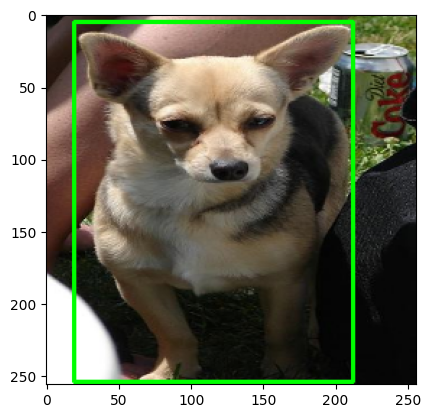

In [20]:
imr = cv2.resize(im01, (256, 256))
boxes = get_bboxes(f'{STANFORD_IMAGE_PATH}/n02085620-Chihuahua/n02085620_10074.jpg',
                annotations_path=STANFORD_ANNOTATIONS_PATH)
boxes = resize_bboxes(boxes, im01.shape, imr.shape)
imann = annotated_image(imr, boxes)
plt.imshow(imann)

In order to prepare for training, lets first save a resized copy of each image. 

In [21]:
#| export
def save_resized(impath, dsize=(256, 256)):
    """
    impath - parent path to images
    dsize - destination image size
    Saves images under the parent folder of impaths under new folder `resized`
    """
    import glob
    import os
    images = glob.glob(f'{impath}/**/*.jpg') + glob.glob(f'{impaths}/**/*.jpeg')
    dstdir = (Path(impath).parent/'resized')
    dstdir.mkdir(parents=True, exist_ok=True)    
    for image in images:
        uniquename = os.sep.join(image.split(os.sep)[-2:])
        img = cv2.imread(image)
        imgr = cv2.resize(img, dsize)
        dst = f'{str(dstdir)}/{uniquename}'
        dst_image_parent = Path(dst).parent
        dst_image_parent.mkdir(exist_ok=True, parents=True)
        cv2.imwrite(dst, imgr)

In [326]:
# this can take a while as it writes resized images
save_resized(STANFORD_IMAGE_PATH)

In [327]:
# Do the same for Tsinghua pets dataset. This will likely take longer
save_resized(TSINGHUA_IMAGE_PATH)

In [22]:
#| export
def get_resized_bboxes(impath, annotations_path, dsize=(256, 256), format='stanford'):
    """
    Gets the bounding boxes of the image given a specified destination resize which
    assumes the image has been resized and is not the original size as provided
    in the annotations file.
    impath - path to the image on disk
    annotations_path - path to corresponding annotations folder
    dsize - Size of the resized image
    format - one of 'stanford' or 'tsinghua'
    """
    assert format in ['stanford', 'tsinghua'], 'Format neither "stanford" nor "tsinghua"'
    import os
    import xml.etree.ElementTree as ET
    parts = impath.split(os.sep)
    imname = Path(os.sep.join(parts[-2:]))
    uniquename = imname.parent/imname.stem
    annotation_file = f'{annotations_path}/{uniquename}'
    if format == 'tsinghua':
        annotation_file += '.jpg.xml'
    root = ET.parse(annotation_file)
    boxes = []
    bndbox_index = 4
    src_w = float(root.find('size')[0].text)
    src_h = float(root.find('size')[1].text)
    bndbox = 'bndbox' if format=='stanford' else 'bodybndbox'
    for obj in root.iter('object'):
        boxelem = obj.find(bndbox)
        left, top, right, bottom = boxelem[0].text, boxelem[1].text, boxelem[2].text, boxelem[3].text
        left, top, right, bottom = map(int, [left, top, right, bottom])
        boxes.append([left, top, right, bottom])
    return resize_bboxes(boxes, (src_h, src_w), dsize)

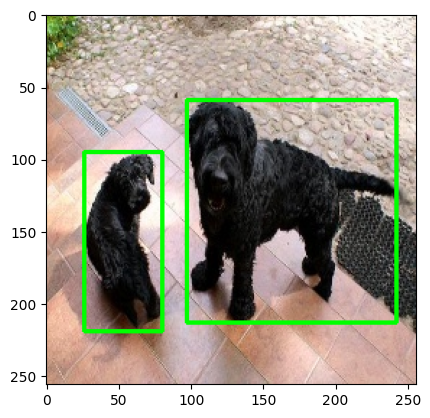

In [23]:
# Quick test
boxes = get_resized_bboxes(f'../data/stanford_dogs/resized/n02097130-giant_schnauzer/n02097130_5668.jpg',
                         annotations_path=STANFORD_ANNOTATIONS_PATH)
im = np.array(Image.open('../data/stanford_dogs/resized/n02097130-giant_schnauzer/n02097130_5668.jpg'))
iman = annotated_image(im, boxes)
plt.imshow(iman)

Now let's get a sample of 16 files and plot them with their bounding boxes.

In [24]:
#| export
def plot_random_images(datadir, n=16):
    """
    datadir - Parent folder where both stanford and tsinghua datasets are
    """
    import glob
    files = glob.glob(f'{datadir}/**/resized/**/*.jpeg') + glob.glob(f'{datadir}/**/resized/**/*.jpg')
    files = np.random.choice(files, size=(n,), replace=False)
    bboxes = []
    format = 'stanford'
    annotations = f'{datadir}/stanford_dogs/Annotation'
    for filepath in files:
        if 'tsinghua' in filepath:
            format = 'tsinghua'
            annotations = f'{datadir}/tsinghua_dogs/Low-Annotations'
        else:
            format = 'stanford'
            annotations = f'{datadir}/stanford_dogs/Annotation'
        boxes = get_resized_bboxes(filepath, annotations, format=format)
        bboxes.append(boxes)
    images = [np.array(Image.open(filepath)) for filepath in files]
    titles = [get_breedname(filepath, normalize=True) for filepath in files]
    annotated_images = [annotated_image(im, bbox) for (im, bbox) in zip(images, bboxes)]
    show_images(annotated_images, titles=titles)

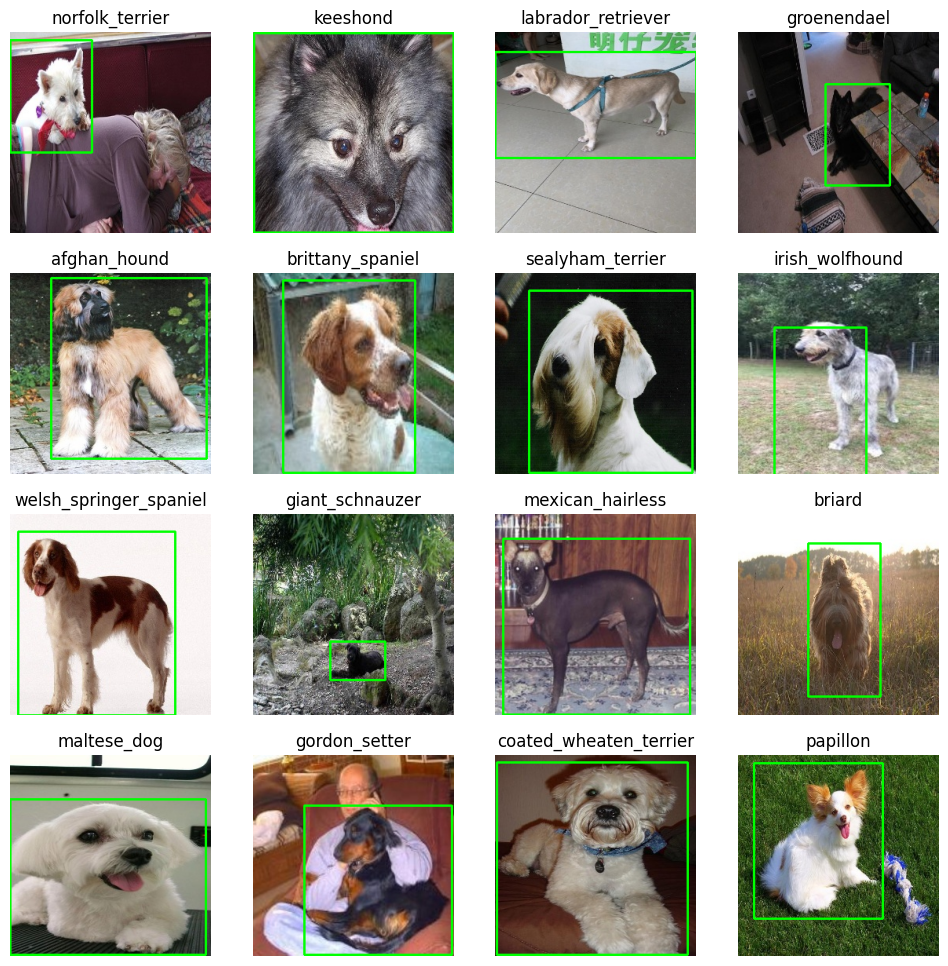

In [25]:
plot_random_images('../data')

In [334]:
#| hide
import nbdev; nbdev.nbdev_export()